# Imports & Dataset Loading

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import numpy as np



2025-10-02 20:50:43.034536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759438243.274628      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759438243.332888      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from torchvision import datasets, transforms

data_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print("Classes:", dataset.classes)
print("Total images:", len(dataset))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total images: 5712


In [3]:
from collections import Counter

# Count images per class
class_counts = Counter(dataset.targets)

print("Number of images per class:")
for idx, class_name in enumerate(dataset.classes):
    print(f"{class_name}: {class_counts[idx]}")


Number of images per class:
glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457


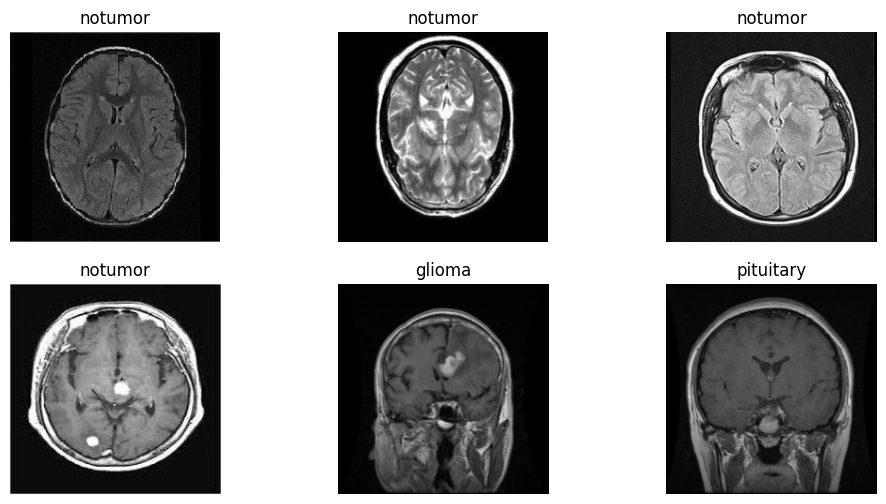

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np
from torchvision.utils import make_grid

# Pick a few random indices
num_samples = 6
indices = random.sample(range(len(dataset)), num_samples)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    img, label = dataset[idx]  # (Tensor, label)
    img = img.permute(1, 2, 0).numpy()  # CHW → HWC for matplotlib

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(dataset.classes[label])
    plt.axis("off")

plt.show()


# Preprocessing

✅ Preprocessing completed. Total images saved: 5712
Images per class:
  pituitary: 1457
  notumor: 1595
  meningioma: 1339
  glioma: 1321


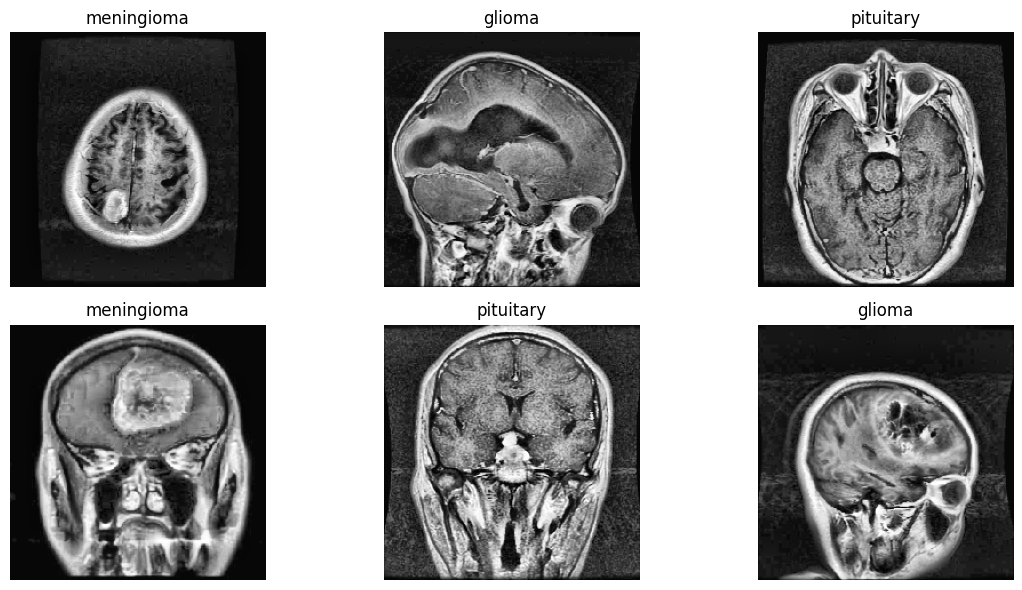

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from skimage import exposure
import cv2
from collections import defaultdict

# Paths
input_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"   # ✅ only Training
output_dir = "/kaggle/working/preprocessed_dataset/Training"
os.makedirs(output_dir, exist_ok=True)

saved_images = []
class_counts = defaultdict(int)

def preprocess_image(img_path, target_size=(224, 224)):
    # Load and resize
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # normalize to [0,1]

    # Convert to grayscale (MRI is usually gray)
    img_array = cv2.cvtColor(img_array.astype("float32"), cv2.COLOR_RGB2GRAY)
    img_array = np.expand_dims(img_array, axis=-1)  # keep channel dimension

    # Contrast enhancement (CLAHE)
    img_array = exposure.equalize_adapthist(img_array, clip_limit=0.03)

    # Ensure values in [0,1]
    img_array = np.clip(img_array, 0, 1)

    return img_array

# Process dataset
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    for filename in os.listdir(class_input_path):
        img_path = os.path.join(class_input_path, filename)
        try:
            img_array = preprocess_image(img_path)

            # Save preprocessed image
            save_path = os.path.join(class_output_path, filename)
            save_img(save_path, img_array)

            saved_images.append((img_array, class_name))
            class_counts[class_name] += 1
        except Exception as e:
            print(f"Skipping {img_path}: {e}")

# ✅ Summary
print(f"✅ Preprocessing completed. Total images saved: {len(saved_images)}")
print("Images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count}")

# Display random preprocessed images
samples = random.sample(saved_images, min(6, len(saved_images)))
plt.figure(figsize=(12, 6))
for i, (img_array, class_name) in enumerate(samples):
    plt.subplot(2, 3, i+1)
    plt.imshow(img_array.squeeze(), cmap="gray")  # show grayscale
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()


# Model Evaluation

In [6]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ----------------- Paths & Parameters -----------------
preprocessed_path = "/kaggle/working/preprocessed_dataset/Training"
IMG_SIZE = (128,128)
BATCH_SIZE = 32
EPOCHS = 50
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ----------------- Data Generators -----------------
# Training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="grayscale",      # ✅ keep grayscale
    batch_size=BATCH_SIZE,
    class_mode='categorical',    # ✅ multi-class
    subset='training',
    shuffle=True
)

# Validation generator (no augmentation, only rescale)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ----------------- Early Stopping -----------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("✅ Training and validation generators with augmentation ready!")
print("Classes:", train_generator.class_indices)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
✅ Training and validation generators with augmentation ready!
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [7]:
def evaluate_and_plot(model, history, test_generator, model_name):
    import os
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    import numpy as np

    # Save model
    model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
    model.save(model_path)
    print(f"{model_name} saved successfully at {model_path}")
    
    # Predict on test/validation set
    test_generator.reset()
    y_pred_prob = model.predict(test_generator, verbose=1)
    
    # Multi-class: take argmax to get class index
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes
    
    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
    
    # Plot accuracy and loss
    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()


# CNN Model

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
✅ Training and validation generators ready!
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759438415.332831      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759438415.333606      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1759438421.162952      92 service.cc:148] XLA service 0x783fd4013820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759438421.164328      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759438421.164353      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759438421.629716      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/143 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.2389 - loss: 3.0429

I0000 00:00:1759438425.885077      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - accuracy: 0.5167 - loss: 1.3619 - val_accuracy: 0.2489 - val_loss: 9.6912
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6459 - loss: 0.8308 - val_accuracy: 0.3173 - val_loss: 11.6700
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7155 - loss: 0.6961 - val_accuracy: 0.3909 - val_loss: 4.3709
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7517 - loss: 0.6276 - val_accuracy: 0.6521 - val_loss: 1.0287
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7650 - loss: 0.6084 - val_accuracy: 0.7029 - val_loss: 0.7890
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7780 - loss: 0.5623 - val_accuracy: 0.6968 - val_loss: 0.9818
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7857 - loss: 0.5439 - val_accuracy: 0.6266 - val_loss: 1.8588
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8052 - loss: 0.5218 - val_accur

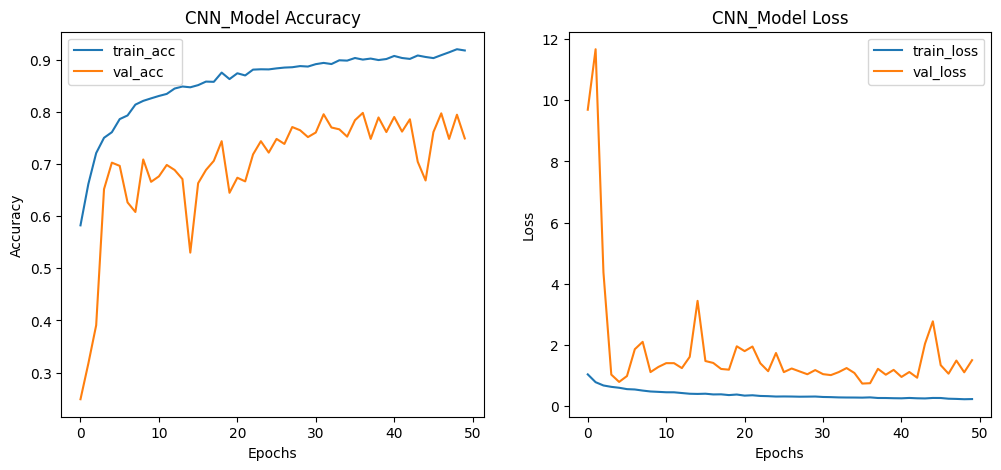

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# =============================
# Paths & Parameters
# =============================
preprocessed_path = "/kaggle/working/preprocessed_dataset/Training"  # Only training dataset
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (128,128)
BATCH_SIZE = 32
EPOCHS = 50  # You can increase to 50 for better training

# =============================
# Data Generators
# =============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="grayscale",      # keep grayscale
    batch_size=BATCH_SIZE,
    class_mode='categorical',    # multi-class
    subset='training',
    shuffle=True
)

# Validation generator
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("✅ Training and validation generators ready!")
print("Classes:", train_generator.class_indices)

# =============================
# Build CNN
# =============================
def build_cnn(input_shape=(128,128,1), num_classes=4):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # 4-class output
    ])
    
    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build & train CNN
cnn_model = build_cnn()
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# =============================
# Evaluation Function (Multi-Class)
# =============================
def evaluate_and_plot(model, history, test_generator, model_name="CNN_Model"):
    # Save model
    model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
    model.save(model_path)
    print(f"{model_name} saved successfully at {model_path}")

    # Predict on validation set
    steps = test_generator.samples // test_generator.batch_size
    if test_generator.samples % test_generator.batch_size != 0:
        steps += 1

    test_generator.reset()
    y_pred_prob = model.predict(test_generator, steps=steps, verbose=1)
    
    # Multi-class: take argmax to get class index
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes
    
    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
    
    # Plot accuracy and loss
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history.get('val_accuracy', []), label='val_acc')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# =============================
# Evaluate CNN
# =============================
evaluate_and_plot(cnn_model, history_cnn, val_generator, "CNN_Model")


# Alexnet

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
✅ Training and validation generators ready!
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 96)     │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,725,572 (94.32 MB)

 Trainable params: 24,722,820 (94.31 MB)

 Non-trainable params: 2,752 (10.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.5223 - loss: 1.5469 - val_accuracy: 0.2314 - val_loss: 4.3075
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7104 - loss: 0.7999 - val_accuracy: 0.2314 - val_loss: 6.9102
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7873 - loss: 0.5790 - val_accuracy: 0.2349 - val_loss: 2.6449
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7926 - loss: 0.5109 - val_accuracy: 0.5372 - val_loss: 1.7886
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8207 - loss: 0.4841 - val_accuracy: 0.6328 - val_loss: 1.3391
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8488 - loss: 0.3822 - val_accuracy: 0.4487 - val_loss: 2.4597
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8511 - loss: 0.3789 - val_accuracy: 0.3944 - val_loss: 5.0588
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8703 - loss: 0.3507 -

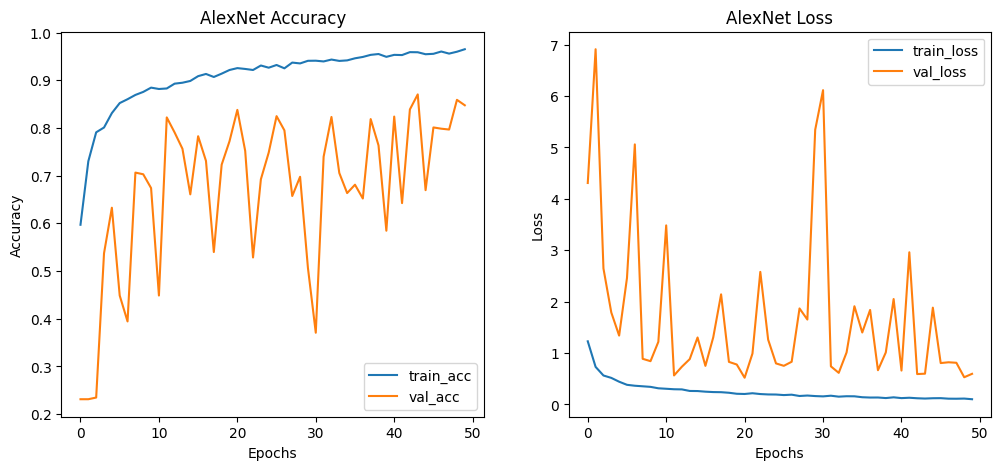

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# =============================
# Paths & Parameters
# =============================
preprocessed_path = "/kaggle/working/preprocessed_dataset/Training"
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (128,128)
BATCH_SIZE = 32
EPOCHS = 50  # Increase for better training
NUM_CLASSES = 4

# =============================
# Data Generators
# =============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # ✅ multi-class
    subset='training',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = val_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("✅ Training and validation generators ready!")
print("Classes:", train_generator.class_indices)

# =============================
# Build AlexNet
# =============================
def build_alexnet(input_shape=(128,128,1), num_classes=NUM_CLASSES):
    model = Sequential([
        Conv2D(96, (11,11), strides=4, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=2),

        Conv2D(256, (5,5), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=2),

        Conv2D(384, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(384, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=2),

        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # 4-class output
    ])
    
    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# =============================
# Train AlexNet
# =============================
alexnet_model = build_alexnet()
alexnet_model.summary()

history_alexnet = alexnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# =============================
# Save Model
# =============================
model_path = os.path.join(MODEL_DIR, "AlexNet_Preprocessed_Augmented.h5")
alexnet_model.save(model_path)
print(f"✅ AlexNet model saved successfully at {model_path}")

# =============================
# Evaluate Model
# =============================
val_generator.reset()
y_pred_prob = alexnet_model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_generator.classes

print("📊 Classification Report for AlexNet:")
print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))

# =============================
# Training Curves
# =============================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_alexnet.history['accuracy'], label='train_acc')
plt.plot(history_alexnet.history.get('val_accuracy', []), label='val_acc')
plt.title("AlexNet Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_alexnet.history['loss'], label='train_loss')
plt.plot(history_alexnet.history.get('val_loss', []), label='val_loss')
plt.title("AlexNet Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


# VGG 16

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
✅ Training and validation generators ready!
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,124 (64.14 MB)

 Trainable params: 2,098,436 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.5852 - loss: 0.9932 - val_accuracy: 0.7046 - val_loss: 0.7962
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.8319 - loss: 0.4721 - val_accuracy: 0.7336 - val_loss: 0.7107
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.8497 - loss: 0.4164 - val_accuracy: 0.7458 - val_loss: 0.7134
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.8588 - loss: 0.3875 - val_accuracy: 0.7599 - val_loss: 0.6579
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.8838 - loss: 0.3371 - val_accuracy: 0.7695 - val_loss: 0.6296
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.8787 - loss: 0.3234 - val_accuracy: 0.7730 - val_loss: 0.6061
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.8883 - loss: 0.3118 - val_accuracy: 0.7774 - val_loss: 0.6215
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.8810 - loss: 0

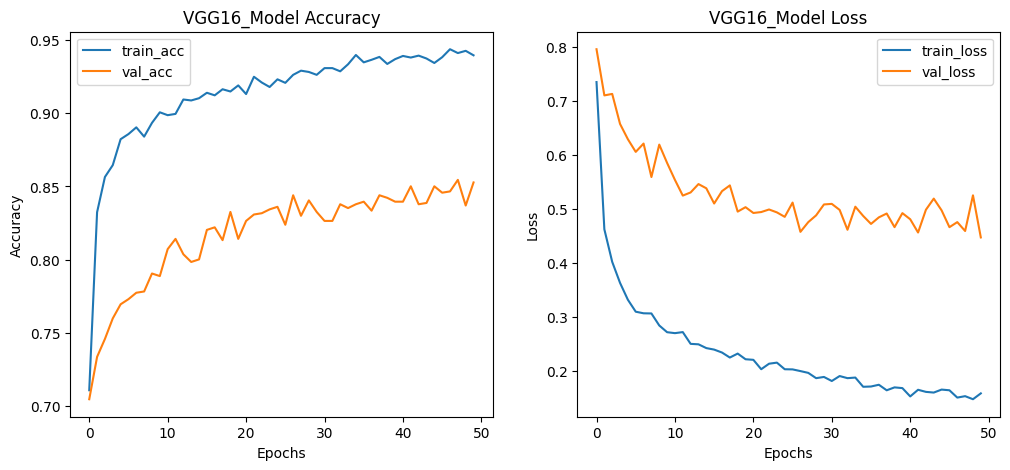

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# =============================
# Paths & Parameters
# =============================
preprocessed_path = "/kaggle/working/preprocessed_dataset/Training"
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (128,128)
BATCH_SIZE = 32
EPOCHS = 50      # Adjust epochs as needed
NUM_CLASSES = 4   # Number of classes

# =============================
# Data Generators (RGB for VGG16)
# =============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="rgb",           # RGB images for VGG16
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    preprocessed_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("✅ Training and validation generators ready!")
print("Classes:", train_generator.class_indices)

# =============================
# Build VGG16 Model
# =============================
def build_vgg16(input_shape=(128,128,3), num_classes=NUM_CLASSES):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze pretrained weights

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # 4-class output
    ])

    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

vgg16_model = build_vgg16()
vgg16_model.summary()

# =============================
# Train VGG16
# =============================
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# =============================
# Evaluation Function
# =============================
def evaluate_and_plot(model, history, test_generator, model_name="Model"):
    import os
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    import numpy as np

    # Save model
    model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
    model.save(model_path)
    print(f"{model_name} saved successfully at {model_path}")

    # Predict on validation set
    steps = test_generator.samples // test_generator.batch_size
    if test_generator.samples % test_generator.batch_size != 0:
        steps += 1

    test_generator.reset()
    y_pred_prob = model.predict(test_generator, steps=steps, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    # Plot accuracy and loss
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history.get('val_accuracy', []), label='val_acc')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# =============================
# Evaluate VGG16
# =============================
evaluate_and_plot(vgg16_model, history_vgg16, val_generator, "VGG16_Model")


# Resnet50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 230ms/step - accuracy: 0.2676 - loss: 1.4728 - val_accuracy: 0.3479 - val_loss: 1.3114
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.3164 - loss: 1.3711 - val_accuracy: 0.3769 - val_loss: 1.2730
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.3844 - loss: 1.3016 - val_accuracy: 0.4084 - val_loss: 1.2170
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.4340 - loss: 1.2701 - val_accuracy: 0.3804 - val_loss: 1.2148
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.4930 - loss: 1.2078 - val_accuracy: 0.4373 - val_loss: 1.1839
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.5117 - loss: 1.1936 - val_accuracy: 0.4847 - val_loss: 1.1512
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.5487 - loss: 1.1457 - val_accuracy: 0.4470 - val_loss: 1.1697
Epoch 8/50
143/143 ━━━━━━━━━━━━━

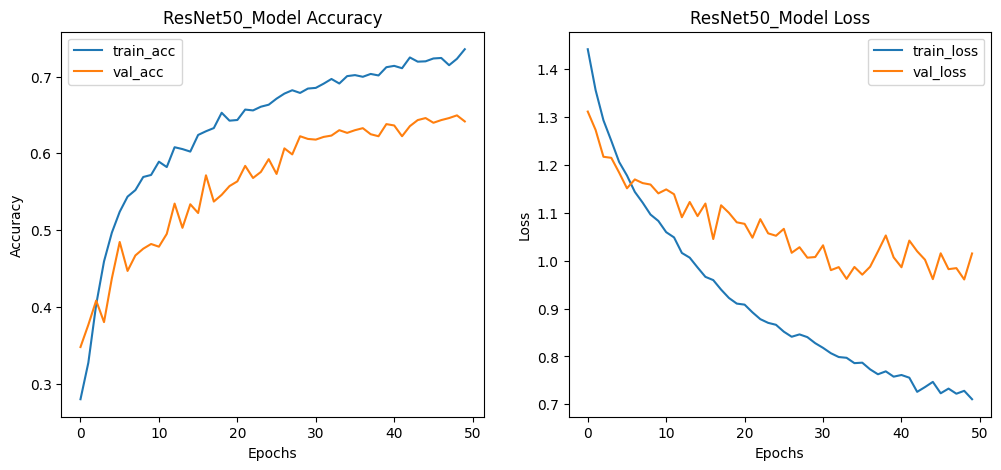

✅ ResNet50 model saved at: /kaggle/working/models/ResNet50_Preprocessed_Augmented.h5


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

# =============================
# Paths
# =============================
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# =============================
# Build ResNet50 Model
# =============================
def build_resnet50(input_shape=(128,128,3), num_classes=4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base_model.trainable = False  # freeze pretrained weights

    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # 4-class output
    ])

    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =============================
# Build & Train
# =============================
resnet_model = build_resnet50(input_shape=(128,128,3), num_classes=4)

history_resnet = resnet_model.fit(
    train_generator,        # preprocessed + augmented training set
    validation_data=val_generator,  # preprocessed validation set
    epochs=50
)

# =============================
# Evaluate
# =============================
evaluate_and_plot(resnet_model, history_resnet, val_generator, "ResNet50_Model")

# =============================
# Save Model
# =============================
model_path = os.path.join(MODEL_DIR, "ResNet50_Preprocessed_Augmented.h5")
resnet_model.save(model_path)
print(f"✅ ResNet50 model saved at: {model_path}")


# DenseNet121

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 367ms/step - accuracy: 0.3866 - loss: 2.1052 - val_accuracy: 0.6372 - val_loss: 0.9494
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.7095 - loss: 0.7341 - val_accuracy: 0.6819 - val_loss: 0.8528
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.7834 - loss: 0.5597 - val_accuracy: 0.6915 - val_loss: 0.8029
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.8106 - loss: 0.5089 - val_accuracy: 0.7099 - val_loss: 0.7927
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.8159 - loss: 0.4788 - val_accuracy: 0.7108 - val_loss: 0.7769
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.8503 - loss: 0.4130 - val_accuracy: 0.7222 - val_loss: 0.7691
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.8557 - loss: 0.3954 - val_accuracy: 0.7274 - val_loss: 0.7473
Epoch 8/50
143/143 ━━━━━━━━━━━━━

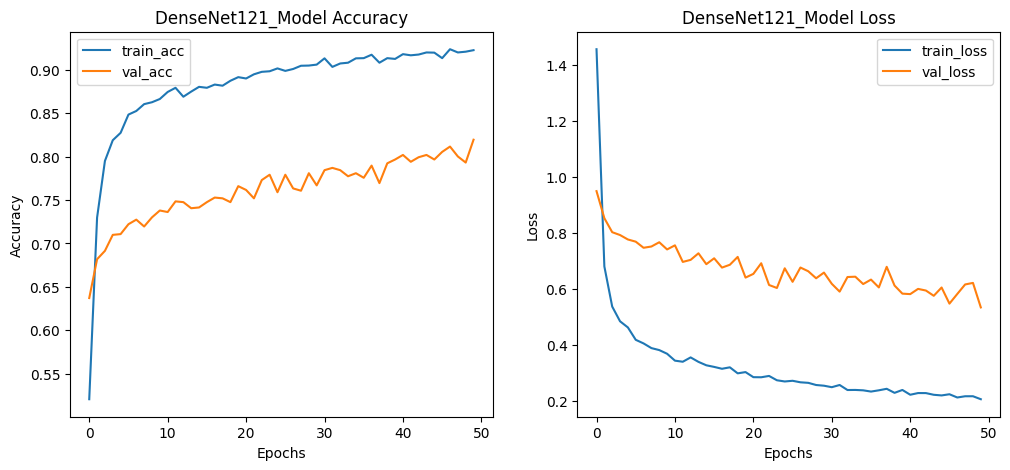

✅ DenseNet121 model saved at: /kaggle/working/models/DenseNet121_Preprocessed_Augmented.h5


In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

# =============================
# Paths
# =============================
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# =============================
# Build DenseNet121 Model
# =============================
def build_densenet(input_shape=(128,128,3), num_classes=4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base_model.trainable = False  # freeze pretrained weights

    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # 4-class output
    ])

    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =============================
# Build & Train
# =============================
densenet_model = build_densenet(input_shape=(128,128,3), num_classes=4)

history_densenet = densenet_model.fit(
    train_generator,        # preprocessed + augmented training set
    validation_data=val_generator,  # preprocessed validation set
    epochs=50
)

# =============================
# Evaluate
# =============================
evaluate_and_plot(densenet_model, history_densenet, val_generator, "DenseNet121_Model")

# =============================
# Save Model
# =============================
model_path = os.path.join(MODEL_DIR, "DenseNet121_Preprocessed_Augmented.h5")
densenet_model.save(model_path)
print(f"✅ DenseNet121 model saved at: {model_path}")


# EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 296ms/step - accuracy: 0.2552 - loss: 1.4166 - val_accuracy: 0.2340 - val_loss: 1.3858
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.2539 - loss: 1.3924 - val_accuracy: 0.2796 - val_loss: 1.3858
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.2452 - loss: 1.3889 - val_accuracy: 0.2796 - val_loss: 1.3824
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.2633 - loss: 1.3848 - val_accuracy: 0.2796 - val_loss: 1.3821
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.2756 - loss: 1.3855 - val_accuracy: 0.2796 - val_loss: 1.3825
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.2831 - loss: 1.3838 - val_accuracy: 0.2796 - val_loss: 1.3814
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.2658 - loss: 1.3839 - val_accuracy: 0.2796 - val_loss: 1.3818
Epoch 8/50
143/143 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


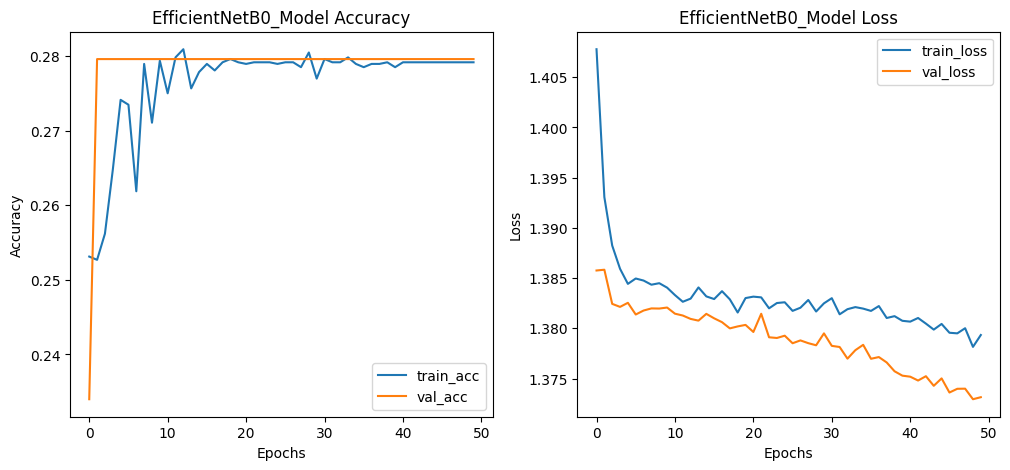

✅ EfficientNetB0 model saved at: /kaggle/working/models/EfficientNetB0_Preprocessed_Augmented.h5


In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

# =============================
# Paths
# =============================
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# =============================
# Build EfficientNetB0 Model
# =============================
def build_efficientnet(input_shape=(128,128,3), num_classes=4):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base_model.trainable = False  # freeze pretrained weights

    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # 4-class output
    ])

    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =============================
# Build & Train
# =============================
efficientnet_model = build_efficientnet(input_shape=(128,128,3), num_classes=4)

history_efficientnet = efficientnet_model.fit(
    train_generator,        # preprocessed + augmented training set
    validation_data=val_generator,  # preprocessed validation set
    epochs=50
)

# =============================
# Evaluate
# =============================
evaluate_and_plot(efficientnet_model, history_efficientnet, val_generator, "EfficientNetB0_Model")

# =============================
# Save Model
# =============================
model_path = os.path.join(MODEL_DIR, "EfficientNetB0_Preprocessed_Augmented.h5")
efficientnet_model.save(model_path)
print(f"✅ EfficientNetB0 model saved at: {model_path}")


# VIT Model

Using device: cuda
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/50], Loss: 0.2787, Val Acc: 0.9326
Epoch [2/50], Loss: 0.0779, Val Acc: 0.9668
Epoch [3/50], Loss: 0.0284, Val Acc: 0.9554
Epoch [4/50], Loss: 0.0277, Val Acc: 0.9370
Epoch [5/50], Loss: 0.0376, Val Acc: 0.9668
Epoch [6/50], Loss: 0.0166, Val Acc: 0.9703
Epoch [7/50], Loss: 0.0149, Val Acc: 0.9711
Epoch [8/50], Loss: 0.0044, Val Acc: 0.9764
Epoch [9/50], Loss: 0.0001, Val Acc: 0.9764
Epoch [10/50], Loss: 0.0000, Val Acc: 0.9764
Epoch [11/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [12/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [13/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [14/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [15/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [16/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [17/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [18/50], Loss: 0.0000, Val Acc: 0.9755
Epoch [19/50], Loss: 0.0000, Val Acc: 0.9746
Epoch [20/50], Loss: 0.0000, Val Acc: 0.9746
Epoch [21/50], Loss: 0.0000, Val Acc: 0.9738
Epoch [22/50], Loss: 0.0000, Val Acc: 0.9738
Epoch [23/50], Loss

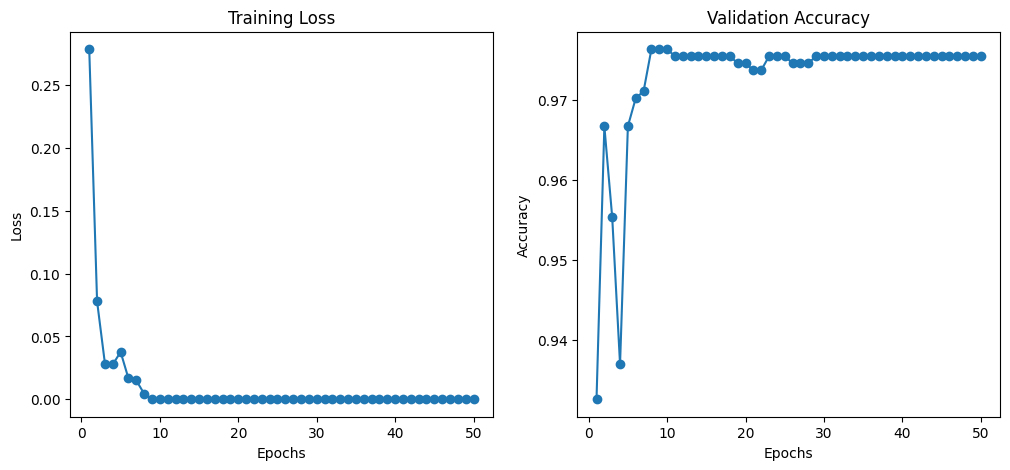

In [14]:
# ==========================
# Imports
# ==========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

# ==========================
# Device
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==========================
# Paths & Parameters
# ==========================
train_path = "/kaggle/working/preprocessed_dataset/Training"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 50  # Increase for better training
LR = 3e-5

# ==========================
# Transforms
# ==========================
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# ==========================
# Dataset & Split
# ==========================
full_dataset = datasets.ImageFolder(train_path, transform=transform_train)
num_classes = len(full_dataset.classes)
print("Classes:", full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms to val_dataset
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================
# Model: ViT-Base-16
# ==========================
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)

# ==========================
# Loss and Optimizer
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ==========================
# Training Loop
# ==========================
train_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")

# ==========================
# Evaluation
# ==========================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# ==========================
# Plot Loss & Accuracy
# ==========================
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()
